<a href="https://colab.research.google.com/github/RainiBenaiah/Summative-ML-Technique-I-Chatbot/blob/main/Menstrual_healthAwareness_model_summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install or upgrade datasets and fsspec
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from datasets import load_dataset

ds = load_dataset("gjyotk/Menstrual-Health-Awareness-Dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/117k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/530 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/45 [00:00<?, ? examples/s]

In [3]:
print(ds["train"][0])

{'instruction (string)': 'What is a normal menstrual cycle length?', 'output (string)': 'A normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.'}


In [4]:
# IMPORTS(NECESSARY LIBRARIES)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score
from transformers import pipeline, set_seed
import torch
from math import exp
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer
from transformers.trainer_callback import EarlyStoppingCallback

In [5]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Data Exploration


In [6]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['instruction (string)', 'output (string)'],
        num_rows: 530
    })
    test: Dataset({
        features: ['instruction (string)', 'output (string)'],
        num_rows: 45
    })
})


In [7]:
# Take a look at the traning sample
print(ds['train'][0])

{'instruction (string)': 'What is a normal menstrual cycle length?', 'output (string)': 'A normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.'}


# Data Visualization

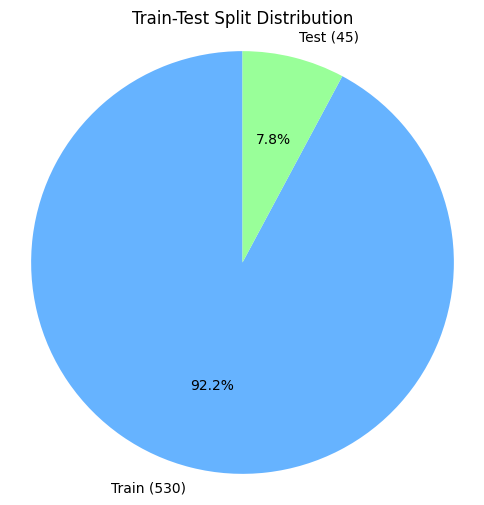

In [8]:
# Dataset Split Distribution (Pie Chart)


sizes = [530, 45]
labels = ['Train (530)', 'Test (45)']
colors = ['#66b3ff', '#99ff99']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Train-Test Split Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

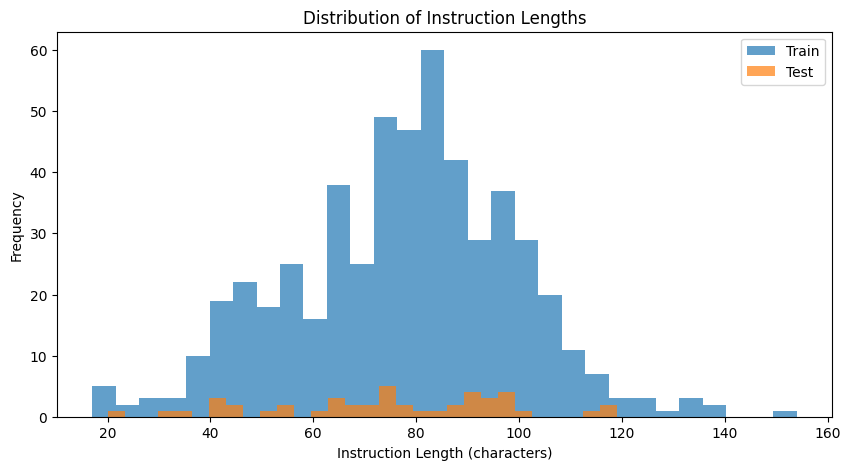

In [9]:
# Instruction Length Distribution (Histogram)

train_instruction_lengths = [len(inst) for inst in ds['train']['instruction (string)']]
test_instruction_lengths = [len(inst) for inst in ds['test']['instruction (string)']]

plt.figure(figsize=(10, 5))
plt.hist(train_instruction_lengths, bins=30, alpha=0.7, label='Train')
plt.hist(test_instruction_lengths, bins=30, alpha=0.7, label='Test')
plt.xlabel('Instruction Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Instruction Lengths')
plt.legend()
plt.show()

<ipython-input-10-1455367618>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_output_lengths, test_output_lengths],


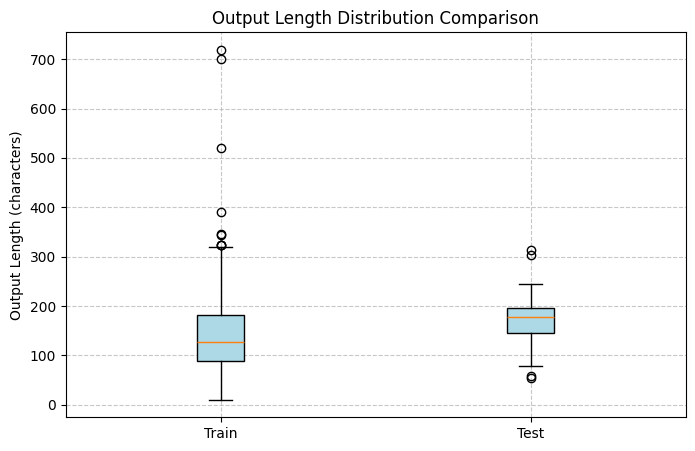

In [10]:
#  Output Length Distribution (Box Plot)

train_output_lengths = [len(out) for out in ds['train']['output (string)']]
test_output_lengths = [len(out) for out in ds['test']['output (string)']]

plt.figure(figsize=(8, 5))
plt.boxplot([train_output_lengths, test_output_lengths],
            labels=['Train', 'Test'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'))
plt.ylabel('Output Length (characters)')
plt.title('Output Length Distribution Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Detailed Preprocessing

In [11]:

# Convert to pandas for analysis
df = pd.DataFrame(ds["train"])
print("Missing values:\n", df.isnull().sum())


Missing values:
 instruction (string)    0
output (string)         0
dtype: int64


In [12]:
# Handles missig values though for our dataset there is no missing values
def handle_missing(example):
    # Fill missing instructions with a placeholder
    if pd.isna(example["instruction (string)"]):
        example["instruction (string)"] = "[QUESTION MISSING]"
    # Fill missing outputs with a placeholder
    if pd.isna(example["output (string)"]):
        example["output (string)"] = "[ANSWER MISSING]"
    return example

ds = ds.map(handle_missing)

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [13]:
print(pd.DataFrame(ds["train"]).isnull().sum())  # (show 0 missing values)

instruction (string)    0
output (string)         0
dtype: int64


In [14]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.5 MB/s eta 0:00:00


In [15]:
import unicodedata
from contractions import fix

def clean_text(text):
    """
    Applies a pipeline of text normalization steps.
    Args:
        text (str): Raw input text
    Returns:
        str: Cleaned, normalized text
    """
    # 1. Fix contractions (e.g., "don't" → "do not")
    text = fix(text)

    # 2. Remove special characters but retain basic punctuation (. , ?)
    text = re.sub(r'[^\w\s.,?]', '', text)

    # 3. Normalize Unicode (e.g., convert é to e)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # 4. Convert to lowercase
    text = text.lower()

    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Correct common menstrual health typos
    typos_dict = {
        "peroid": "period",
        "menstruel": "menstrual",
        "pcos": "pcos"  # Preserve acronyms
    }
    for typo, correction in typos_dict.items():
        text = re.sub(r'\b' + typo + r'\b', correction, text)

    return text

# Apply to dataset
ds = ds.map(lambda x: {
    "instruction (string)": clean_text(x["instruction (string)"]),
    "output (string)": clean_text(x["output (string)"])
})

# Verify
print("Before:", "What’s a NORMAL menstrual cycle length? (Answer please!)")
print("After:", clean_text("What’s a NORMAL menstrual cycle length? (Answer please!)"))

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Before: What’s a NORMAL menstrual cycle length? (Answer please!)
After: what is a normal menstrual cycle length? answer please


# Verifying Data Formatting

In [16]:
def format_for_gpt2(example):
    text = f"Instruction: {example['instruction (string)']}\nOutput: {example['output (string)']}\n\n"
    return {"text": text}

formatted_ds = ds.map(format_for_gpt2)
print(formatted_ds["train"][0]["text"])  # Verify formatting

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Instruction: what is a normal menstrual cycle length?
Output: a normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.




# Step 2: Tokenizing the Data

In [17]:
from transformers import GPT2Tokenizer

# Initialize tokenizer (force padding for GPU efficiency)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize(examples):
    # Tokenize inputs (with padding/truncation)
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt"  # Returns PyTorch tensors for GPU
    )

    # Create labels for causal LM (shifted input_ids)
    labels = tokenized_inputs["input_ids"].clone()
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply tokenization (batched for speed)
tokenized_ds = formatted_ds.map(tokenize, batched=True, batch_size=32)

# Inspect sample
sample = tokenized_ds["train"][0]
print("Keys:", sample.keys())  # will show: ['input_ids', 'attention_mask', 'labels']
print("Input IDs:", sample["input_ids"][:10])  # First 10 tokens
print("Labels:", sample["labels"][:10])  #  match input_ids (for causal LM)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Keys: dict_keys(['instruction (string)', 'output (string)', 'text', 'input_ids', 'attention_mask', 'labels'])
Input IDs: [6310, 2762, 25, 644, 318, 257, 3487, 37230, 6772, 4129]
Labels: [6310, 2762, 25, 644, 318, 257, 3487, 37230, 6772, 4129]


# Setting up GPU Acceleration

In [18]:


# Enable CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimizes CUDA ops

# Move data to GPU
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Fine-Tuning pre-trained Transformer model (gpt-2)

In [19]:

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Model
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# Training args - with W&B disabled
training_args = TrainingArguments(
    output_dir="./results",
    run_name="gpt2-menstrual-health-v1",
    weight_decay=0.05,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=100,
    eval_strategy="steps",
    eval_steps=100,
    fp16=True,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",  # Disables W&B
    dataloader_num_workers=2,
    learning_rate=1e-5,
    warmup_ratio=0.2,
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)

# Start training
trainer.train()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,1.437500,1.303337
200,0.756100,0.764056
300,0.632300,0.660335
400,0.539000,0.608420
500,0.474400,0.572096
600,0.461600,0.552584
700,0.398600,0.540800
800,0.373700,0.532963


Step,Training Loss,Validation Loss
100,1.437500,1.303337
200,0.756100,0.764056
300,0.632300,0.660335
400,0.539000,0.608420
500,0.474400,0.572096
600,0.461600,0.552584
700,0.398600,0.540800
800,0.373700,0.532963
900,0.351200,0.530428
1000,0.326900,0.526595


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1700, training_loss=0.7047149722716387, metrics={'train_runtime': 810.6756, 'train_samples_per_second': 65.378, 'train_steps_per_second': 2.097, 'total_flos': 3462119424000000.0, 'train_loss': 0.7047149722716387, 'epoch': 100.0})

In [20]:
# Save the model after training
trainer.save_model("./my_gpt2_model")

# Load it (Later use)

model = GPT2LMHeadModel.from_pretrained("./my_gpt2_model")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [21]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer


# 1. Load your trained model and tokenizer
model_path = "/content/my_gpt2_model"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as PAD token

# 2. Create a generation function
def generate_response(prompt, max_length=150, temperature=0.9, top_k=50, top_p=0.95):
    """
    Generate a response given a prompt.

    Args:
        prompt (str): Input text to generate from.
        max_length (int): Maximum length of generated text.
        temperature (float): Controls randomness (lower = more deterministic).
        top_k (int): Top-k sampling.
        top_p (float): Nucleus sampling (0.95 works well).

    Returns:
        str: Generated response.
    """
    # Encode the input prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate text
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,  # Avoids pad token warning
        num_return_sequences=1
    )

    # Decode and clean up the output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove the input prompt from the response
    response = response.replace(prompt, "").strip()
    return response



In [22]:
# 3. Test the function
prompt = "What is PMS?"
response = generate_response(prompt)
print(f"Prompt: {prompt}\nResponse: {response}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Prompt: What is PMS?
Response: PMS is a common medical condition caused by abnormal menstrual cycles and other hormonal imbalances that disrupt normal menstrual cycles. it is caused by hormonal changes such as changes in estrogen and progesterone levels, excess follicular activity, and changes in the distribution of sperm and other important bodily fluids.


# Model Evaluation

In [23]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00



Qualitative Evaluation:

Sample 1:
Prompt: What is PMS?
Generated: PMS is a chronic disorder characterized by excessive changes in menstrual hormone levels and changes in blood pressure and body temperature fluctuations due to hormonal fluctuations. symptoms may include irregular periods, heavy menstrual bleeding, painful periods, and changes in libido or selfconsciousness.
Reference: PMS (Premenstrual Syndrome) includes mood swings, bloating, and fatigue before periods.
BLEU: 0.02 | F1: 0.09 | PPL: 7.17

Sample 2:
Prompt: How to manage cramps?
Generated: · Use medication to manage menstrual cramps, such as ibuprofen or acetaminophen, as needed to manage symptoms such as constipation and bloating.
Reference: Manage cramps with heat pads, ibuprofen, and light exercise.
BLEU: 0.03 | F1: 0.15 | PPL: 10.66

Sample 3:
Prompt: Symptoms of ovulation?
Generated: Solution: the uterus begins to contract.
Reference: Ovulation symptoms are mild pelvic pain, increased discharge, and libido changes

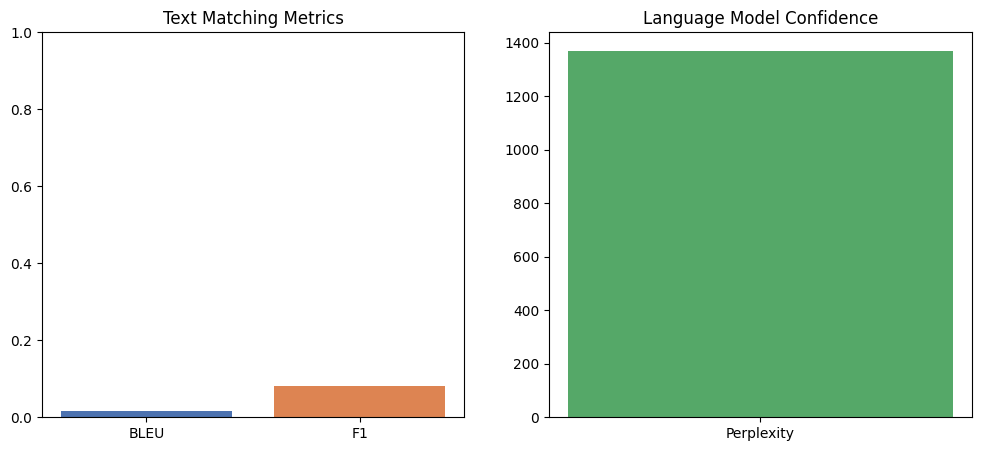

In [25]:

# Load test data
test_prompts = ["What is PMS?", "How to manage cramps?", "Symptoms of ovulation?"]
test_references = [
    "PMS (Premenstrual Syndrome) includes mood swings, bloating, and fatigue before periods.",
    "Manage cramps with heat pads, ibuprofen, and light exercise.",
    "Ovulation symptoms are mild pelvic pain, increased discharge, and libido changes."
]

# Generate responses
generated_responses = [generate_response(prompt) for prompt in test_prompts]

# --- BLEU Score ---
def calculate_bleu(generated, reference):
    smoothie = SmoothingFunction().method4
    return sentence_bleu(
        [reference.split()],
        generated.split(),
        smoothing_function=smoothie,
        weights=(0.5, 0.5, 0, 0)  # Bigram-focused
    )

bleu_scores = [calculate_bleu(gen, ref) for gen, ref in zip(generated_responses, test_references)]

# --- F1 Score ---
def token_f1(generated, reference):
    gen_tokens = set(generated.lower().split())
    ref_tokens = set(reference.lower().split())
    common = gen_tokens & ref_tokens
    precision = len(common) / (len(gen_tokens) + 1e-9)
    recall = len(common) / (len(ref_tokens) + 1e-9)
    return 2 * (precision * recall) / (precision + recall + 1e-9)

f1_scores = [token_f1(gen, ref) for gen, ref in zip(generated_responses, test_references)]

# --- Perplexity (Manual Calculation) ---
def calculate_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", return_attention_mask=False).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    return exp(outputs.loss.item())

ppl_scores = [calculate_perplexity(response) for response in generated_responses]

# --- Qualitative Analysis ---
print("\nQualitative Evaluation:")
for i, (prompt, gen, ref) in enumerate(zip(test_prompts, generated_responses, test_references)):
    print(f"\nSample {i+1}:")
    print(f"Prompt: {prompt}")
    print(f"Generated: {gen}")
    print(f"Reference: {ref}")
    print(f"BLEU: {bleu_scores[i]:.2f} | F1: {f1_scores[i]:.2f} | PPL: {ppl_scores[i]:.2f}")

# --- Visualization ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["BLEU", "F1"], [np.mean(bleu_scores), np.mean(f1_scores)], color=['#4C72B0', '#DD8452'])
plt.title("Text Matching Metrics")
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(["Perplexity"], [np.mean(ppl_scores)], color='#55A868')
plt.title("Language Model Confidence")
plt.show()

In [26]:
# Medical Accuracy Evaluation
medical_keywords = {
    "pms": ["mood", "bloat", "fatigue"],
    "cramps": ["heat", "ibuprofen", "exercise"],
    "ovulation": ["pain", "discharge", "libido"]
}

def check_medical_accuracy(response, topic):
    topic = topic.lower()
    required = medical_keywords.get(topic, [])
    found = sum(1 for kw in required if kw in response.lower())
    return found / len(required) if required else 0

def evaluate_medical_responses(prompts, responses):
    results = []
    for prompt, response in zip(prompts, responses):
        # Detect topic from prompt
        topic = next((k for k in medical_keywords if k in prompt.lower()), "general")
        accuracy = check_medical_accuracy(response, topic)

        # Identify missing keywords
        missing = [kw for kw in medical_keywords.get(topic, []) if kw not in response.lower()]

        # Determine severity
        severity = "High Risk" if any(kw in ['ibuprofen', 'pain'] for kw in missing) else "Medium" if missing else "Good"

        results.append({
            "topic": topic.upper(),
            "response": response,
            "accuracy": accuracy,
            "missing": missing,
            "severity": severity
        })
    return results

# Run evaluation
medical_eval = evaluate_medical_responses(test_prompts, generated_responses)

# Print formatted results
print("\nComprehensive Medical Evaluation:")
for i, res in enumerate(medical_eval):
    print(f"\nCase {i+1} - {res['topic']} ({res['severity']}):")
    print(f"► Response: {res['response']}")
    print(f"► Accuracy: {res['accuracy']:.0%}")
    print(f"► Missing: {', '.join(res['missing']) or 'None'}")
    if res['severity'] == "High Risk":
        print(" Warning: Missing critical safety keywords")
    print("-" * 80)


Comprehensive Medical Evaluation:

Case 1 - PMS (Medium):
► Response: PMS is a chronic disorder characterized by excessive changes in menstrual hormone levels and changes in blood pressure and body temperature fluctuations due to hormonal fluctuations. symptoms may include irregular periods, heavy menstrual bleeding, painful periods, and changes in libido or selfconsciousness.
► Accuracy: 0%
► Missing: mood, bloat, fatigue
--------------------------------------------------------------------------------

Case 2 - CRAMPS (Medium):
► Response: · Use medication to manage menstrual cramps, such as ibuprofen or acetaminophen, as needed to manage symptoms such as constipation and bloating.
► Accuracy: 33%
► Missing: heat, exercise
--------------------------------------------------------------------------------

Case 3 - OVULATION (High Risk):
► Response: Solution: the uterus begins to contract.
► Accuracy: 0%
► Missing: pain, discharge, libido
------------------------------------------------

In [30]:
import torch

# Set the format for PyTorch
tokenized_ds.set_format("torch")

# Define batch size
batch_size = 8

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(tokenized_ds["train"], batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(tokenized_ds["test"], batch_size=batch_size)

# Inspect a batch
for batch in train_dataloader:
    print("Batch keys:", batch.keys())
    print("Input IDs shape:", batch["input_ids"].shape)
    print("Attention Mask shape:", batch["attention_mask"].shape)
    print("Labels shape:", batch["labels"].shape)
    break

Batch keys: dict_keys(['instruction (string)', 'output (string)', 'text', 'input_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([8, 128])
Attention Mask shape: torch.Size([8, 128])
Labels shape: torch.Size([8, 128])


In [43]:
from google.colab import files
import json

# Get the current notebook's content (requires IPython)
from IPython.display import Javascript

# Force-save the notebook first (Colab autosave may not be instant)
Javascript("IPython.notebook.save_notebook()")

# Fetch the notebook's filename dynamically
notebook_name = ""
def set_notebook_name(name):
  global notebook_name
  notebook_name = name

get_notebook_name_js = """
  const notebookName = IPython.notebook.notebook_name;
  google.colab.kernel.invokeFunction('set_notebook_name', [notebookName], {});
"""

Javascript(get_notebook_name_js)

# Wait a moment for save to complete and notebook name to be set
import time
time.sleep(3) # Increased sleep time

# Now read the notebook
notebook_path = f"/content/Menstrual_healthAwareness_model_summative.ipynb"
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

# Remove problematic widget metadata
if 'metadata' in notebook and 'widgets' in notebook['metadata']:
    del notebook['metadata']['widgets']

# Save the cleaned notebook
cleaned_path = "cleaned_" + 'Menstrual-healthAwareness-model-summative.ipynb'
with open(cleaned_path, 'w', encoding='utf-8') as f:
    json.dump(notebook, f)

# Download the cleaned file
files.download(cleaned_path)
print(" Downloaded cleaned notebook.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded cleaned notebook.
